<a href="https://colab.research.google.com/github/nataliamarinn/dma-ros/blob/main/NM_pruebas_nuestras_caras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Código para lectura de imágenes y aplicación de CP***


En este notebook se realiza la lectura de imágenes desde una carpeta, se seleccionan fotos para training y testing, se recortan los rostros, se convierten a escala de grises y luego se aplica el **Análisis de componentes principales** (PCA)

In [1]:
#Clonar el repo para obtener los archivos
!git clone https://github.com/nataliamarinn/dm_grupo4.git


Cloning into 'dm_grupo4'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 279 (delta 0), reused 0 (delta 0), pack-reused 276 (from 1)
Receiving objects: 100% (279/279), 710.13 MiB | 21.47 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (255/255), done.


In [2]:

# ✅ Primero desinstalamos protobuf conflictivo
!pip uninstall -y protobuf

# ✅ Luego instalamos versiones compatibles
!pip install mediapipe==0.10.5 protobuf==3.20.3 opencv-python-headless

Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [6]:
#!pip install mediapipe --quiet


In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [2]:
# Ruta donde están las carpetas de personas
input_folder = "/content/dm_grupo4/Eigenfaces"


In [3]:
# Inicializar MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1)

# Puntos que delimitan la cara sin pelo/ropa
face_indices = [33, 133, 362, 263, 1, 2, 98, 327, 152, 10, 176, 397, 365, 379, 378, 400, 377]

In [4]:
# Almacenar imágenes procesadas y etiquetas
imagenes_procesadas = []
etiquetas = []

In [5]:
# Recorrer carpetas/personas
for persona in os.listdir(input_folder):
    carpeta = os.path.join(input_folder, persona)
    if os.path.isdir(carpeta):
        for archivo in os.listdir(carpeta):
            if archivo.lower().endswith((".jpg", ".jpeg", ".png")):
                path_img = os.path.join(carpeta, archivo)
                image = cv2.imread(path_img)
                if image is None:
                    continue

                h, w, _ = image.shape
                img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(img_rgb)

                if results.multi_face_landmarks:
                    landmarks = results.multi_face_landmarks[0].landmark
                    puntos = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in face_indices]

                    x_min = max(min(p[0] for p in puntos), 0)
                    x_max = min(max(p[0] for p in puntos), w)
                    y_min = max(min(p[1] for p in puntos), 0)
                    y_max = min(max(p[1] for p in puntos), h)

                    rostro = image[y_min:y_max, x_min:x_max]

                    if rostro.size == 0:
                        continue

                    # Convertir a escala de grises
                    rostro_gray = cv2.cvtColor(rostro, cv2.COLOR_BGR2GRAY)

                    # Redimensionar a 30x30
                    rostro_redimensionado = cv2.resize(rostro_gray, (30, 30))

                    # Guardar imagen procesada y su etiqueta
                    imagenes_procesadas.append(rostro_redimensionado)
                    etiquetas.append(persona)

print(f"✅ Total imágenes procesadas: {len(imagenes_procesadas)}")

✅ Total imágenes procesadas: 253


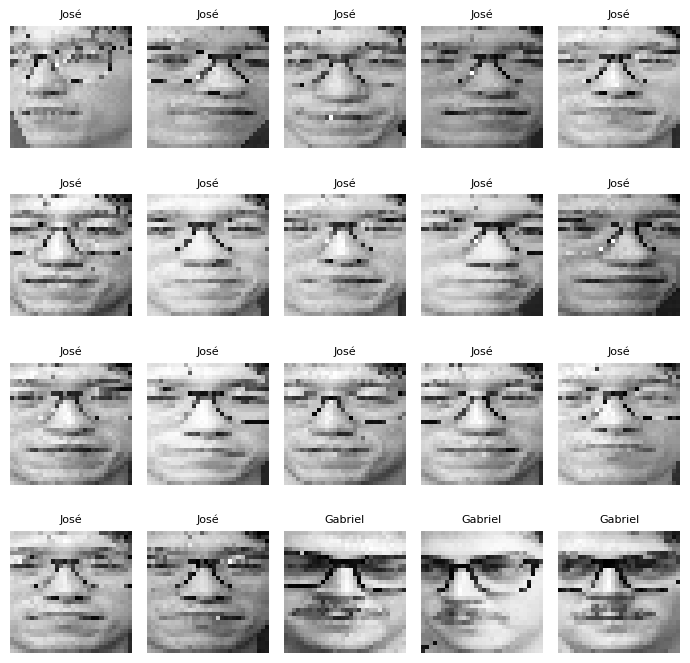

In [12]:
fig, axs = plt.subplots(4,5, figsize=(7, 7))
for i, ax in enumerate(axs.flat):
    ax.imshow(imagenes_procesadas[i+4], cmap='gray', interpolation='nearest')
    ax.set_title(etiquetas[i+4], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Guardado

In [13]:
import os
import cv2

output_folder = "/content/caras_30x30"
os.makedirs(output_folder, exist_ok=True)

filenames = []

for i, img in enumerate(imagenes_procesadas):
    filename = f"cara_{i}.jpg"
    path = os.path.join(output_folder, filename)
    cv2.imwrite(path, img)
    filenames.append(filename)


In [14]:
import pandas as pd

df = pd.DataFrame({
    "filename": filenames,
    "label": etiquetas
})

csv_path = "/content/caras_30x30_etiquetas.csv"
df.to_csv(csv_path, index=False)

print(f"✅ CSV guardado en: {csv_path}")


✅ CSV guardado en: /content/caras_30x30_etiquetas.csv


In [15]:
df.head()

,filename,label
0,cara_0.jpg,José
1,cara_1.jpg,José
2,cara_2.jpg,José
3,cara_3.jpg,José
4,cara_4.jpg,José


# ***ACP***

In [11]:
import os
import cv2
import numpy as np
import pandas as pd

In [16]:
# Paths
folder = "/content/caras_30x30"
csv_labels = "/content/caras_30x30_etiquetas.csv"


In [17]:
df = pd.read_csv(csv_labels)

X = []
y = []

for _, row in df.iterrows():
    filename = row['filename']
    label = row['label']
    path = os.path.join(folder, filename)

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_flat = img.flatten()
        X.append(img_flat)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Total imágenes cargadas: {X.shape}, Labels: {len(np.unique(y))}")
y = np.array(y)

✅ Total imágenes cargadas: (253, 900), Labels: 13


In [18]:
#Dividir en entrenamiento y test (con representación por clase)

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"🔹 Train: {X_train.shape[0]} muestras")
print(f"🔹 Test:  {X_test.shape[0]} muestras")

🔹 Train: 202 muestras
🔹 Test:  51 muestras


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
from sklearn.decomposition import PCA

# Queremos calcular TODAS las componentes posibles
pca = PCA()  # sin limitar n_components
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)

print(f"🔍 Componentes disponibles: {X_train_pca_full.shape[1]}")


🔍 Componentes disponibles: 202


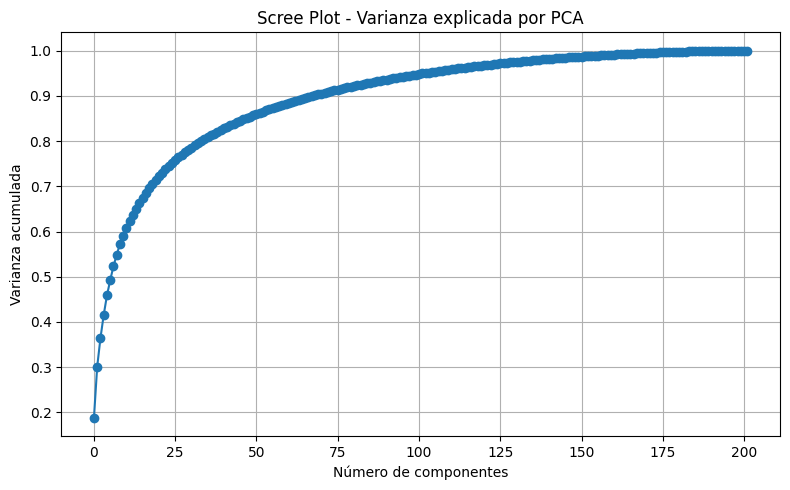

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("Scree Plot - Varianza explicada por PCA")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
var_cumulada = np.cumsum(pca.explained_variance_ratio_)
n_85 = np.argmax(var_cumulada >= 0.85) + 1
print(f"📌 Se necesitan {n_85} componentes para explicar el 85% de la varianza")


📌 Se necesitan 48 componentes para explicar el 85% de la varianza


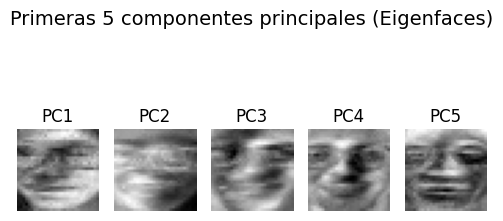

In [28]:
k = 5  # Número de componentes principales a visualizar
fig, axs = plt.subplots(1, k, figsize=(5, 3))
fig.suptitle(f"Primeras {k} componentes principales (Eigenfaces)", fontsize=14)
for i in range(k):
    eigenface = pca.components_[i].reshape(30, 30)
    axs[i].imshow(eigenface, cmap='gray')
    axs[i].set_title(f"PC{i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

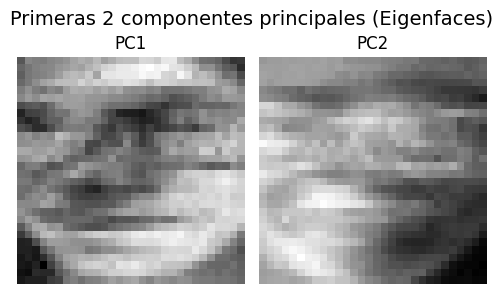

In [30]:
k = 2  # Número de componentes principales a visualizar
fig, axs = plt.subplots(1, k, figsize=(5, 3))
fig.suptitle(f"Primeras {k} componentes principales (Eigenfaces)", fontsize=14)
for i in range(k):
    eigenface = pca.components_[i].reshape(30, 30)
    axs[i].imshow(eigenface, cmap='gray')
    axs[i].set_title(f"PC{i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()